<a href="https://colab.research.google.com/github/bradshawjoshua/first-neural-network/blob/main/Simple_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle
Source of Data: https://www.kaggle.com/fedesoriano/heart-failure-prediction

##Creating a deep learning model to predict heart disease in populations at risk.  

###Data Dictionary Info:

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
10. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
11. HeartDisease: output class [1: heart disease, 0: Normal]




#Imports and Functions

In [ ]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from seaborn import heatmap

from sklearn.metrics import classification_report, \
ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.tree import plot_tree
from sklearn import set_config
set_config(display='diagram')

In [ ]:
# defining function for classification reporting
def evaluate_classification(y_true, y_pred, labels=None, normalize=None):
  print(classification_report(y_true, y_pred, target_names=labels))

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          display_labels=labels, 
                                          normalize=normalize,
                                          cmap='Blues')
  plt.show()

In [ ]:
# plotting function (source: https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0)
'''
Functions to Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [ ]:
# plotting function for model viz
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

#Data Cleaning

In [ ]:
# loading heart disease data set
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQVCM6eVEirjKwWV9k9H2MvumunBVCLC9ATD9jTDt8WPqNFnxdBbZdB09-uesZoCS3PMvb6TbKZ54nA/pub?gid=162927751&single=true&output=csv')

In [ ]:
# scanning dtypes, nothing looks off
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# checking for dupes
df.duplicated().sum()

0

In [ ]:
# looking for missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
# creating a copy for df machine learning (ml)
df_ml = df.copy()

#Quick Exploration

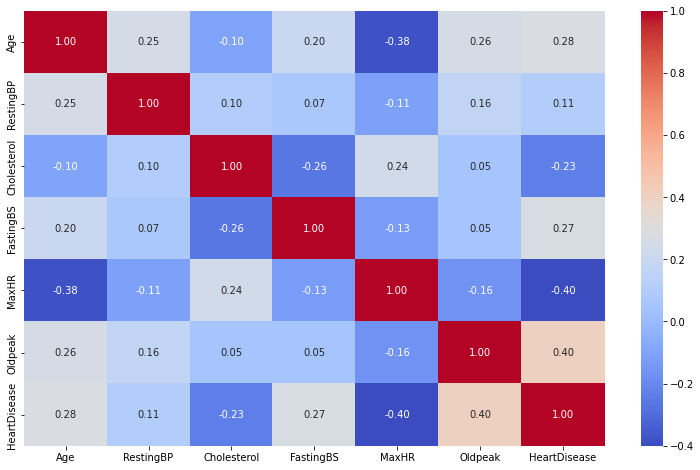

In [ ]:
# instantiating a heatmap
corr = df.corr()
corr

plt.figure(figsize=(13,8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt ='.2f')

>Oldpeak has the highest positive correlation to our target, and MaxHR has the highest negative correlation. Age and FastingBS are just behind the top two aforementioned.

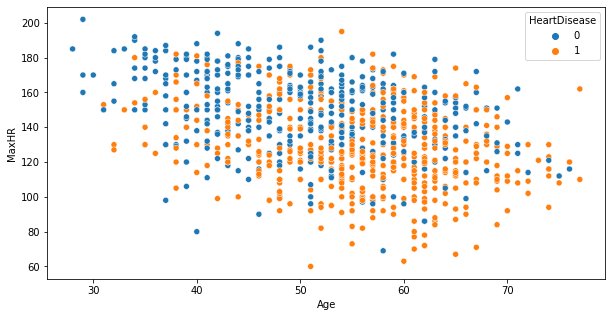

In [ ]:
# (0) for no heart disease; (1) for heart disease
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x = 'Age', y ='MaxHR', hue='HeartDisease')

>From our heatmap, we can see that MaxHR and HeartDisease show a negative correlation, and we can also see that older patients are most affected. This may indicate that older adults are more sedentary than young and middle adults.

In [ ]:
# scanning for extreme outliers
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Model Development

In [ ]:
# defining my X and y & train test split
X = df_ml.drop(columns = 'HeartDisease')
y = df_ml['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
# creating column selectors for transformer
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [ ]:
# instantiating MinMaxScaler and the OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [ ]:
# making tuples for preprocessing
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)

In [ ]:
# instatiating the col transfomer with tuples
col_transformer = make_column_transformer(cat_tuple, num_tuple, remainder = 'passthrough')

In [ ]:
# fitting only on training data
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa2e3444e10>),
                                ('minmaxscaler', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa2e344a250>)])

In [ ]:
# transforming both training and test sets
X_train_proc = col_transformer.transform(X_train)
X_test_proc = col_transformer.transform(X_test)

#1st Model Deployment

In [ ]:
# building binary classification (cl1) model

# instantiating the model
cl_model = Sequential()

# creating input layer =
cl_model.add(Dense(10, activation= 'relu', input_dim = X_train_proc.shape[1]))

# creating hidden layer 1
cl_model.add(Dense(5, activation= 'relu'))

# creating hidden layer 2
cl_model.add(Dense(2, activation= 'relu'))

# creating output layer, binary class requires my activation fx of my final layer to be sigmoid
cl_model.add(Dense(1, activation='sigmoid'))

# displaying my model details
cl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


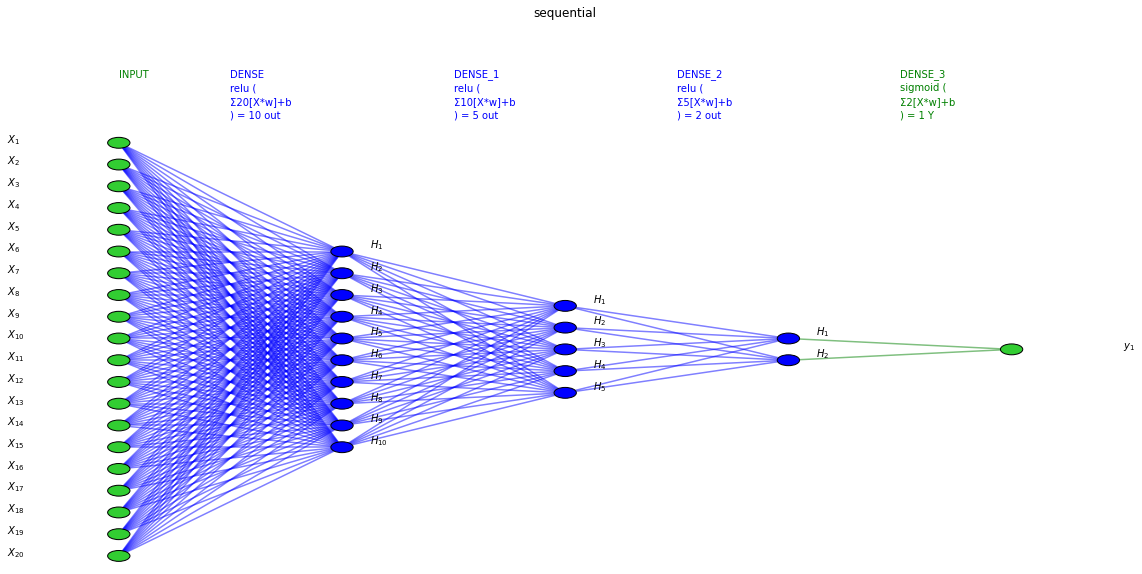

In [ ]:
# showing summary viz of my neural network
visualize_nn(cl_model, description=True, figsize=(20,10))

In [ ]:
# using binary_crossentropy
# compiling my first model, setting metrics = ['acc']

cl_model.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

In [ ]:
# fitting my first model
history = cl_model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 100, verbose =0)

>At first, I used 300 epochs; after changing it to 100, I observed a dramatic improvement.

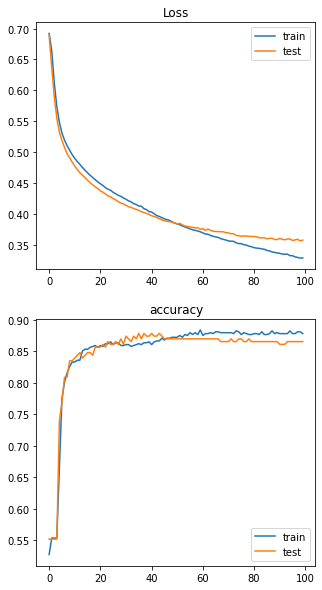

In [ ]:
# displaying first model performance
plot_history(history, 'accuracy')

>Train and test look relatively balanced. Let's see if I can improve my model's accuracy from around 87% to over 95% without overfitting it. I will display the test metrics for this first model below.

# 1st Model Metrics Report

Training Evaluation:

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.85      0.87       307
   Heart Disease       0.88      0.91      0.90       381

        accuracy                           0.88       688
       macro avg       0.88      0.88      0.88       688
    weighted avg       0.88      0.88      0.88       688



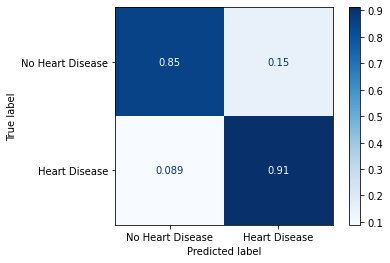

Testing Evaluation:

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.81      0.84       103
   Heart Disease       0.85      0.91      0.88       127

        accuracy                           0.87       230
       macro avg       0.87      0.86      0.86       230
    weighted avg       0.87      0.87      0.86       230



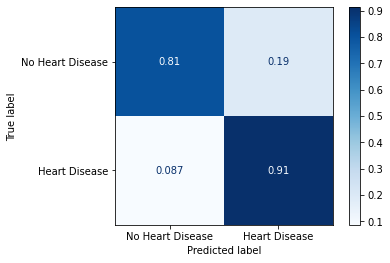

In [ ]:
# predicitons and evaluating first model
# defining labels for my confusion matrix
labels = ['No Heart Disease', 'Heart Disease']

# getting predictions and rounding them to integers instead of floats
train_preds = np.rint(cl_model.predict(X_train_proc))
test_preds = np.rint(cl_model.predict(X_test_proc))

# evaluating training set
print('Training Evaluation:\n')
evaluate_classification(y_train, train_preds, labels=labels,
                        normalize='true')
print('Testing Evaluation:\n')
# showing confusion Matrix
evaluate_classification(y_test, test_preds, labels=labels,
                        normalize='true')

>Let's see if I can get my test model metrics to perform above 95% accuracy, precision, and recall by adding more layers.

#2nd Model Deployment
Adding one more layer

In [ ]:
# building binary classification (cl2) model

# instantiating the second model
cl2_model = Sequential()

# creating input layer
cl2_model.add(Dense(10, activation= 'tanh', input_dim = X_train_proc.shape[1]))

# creating hidden layer 1
cl2_model.add(Dense(7, activation= 'tanh'))

# creating hidden layer 2
cl2_model.add(Dense(5, activation= 'tanh'))

# creating hidden layer 3
cl2_model.add(Dense(3, activation= 'tanh'))

# creating output layer, binary class requires my activation fx of my final layer to be sigmoid
cl2_model.add(Dense(1, activation='sigmoid'))

# displaying my model details
cl2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
 dense_6 (Dense)             (None, 5)                 40        
                                                                 
 dense_7 (Dense)             (None, 3)                 18        
                                                                 
 dense_8 (Dense)             (None, 1)                 4         
                                                                 
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


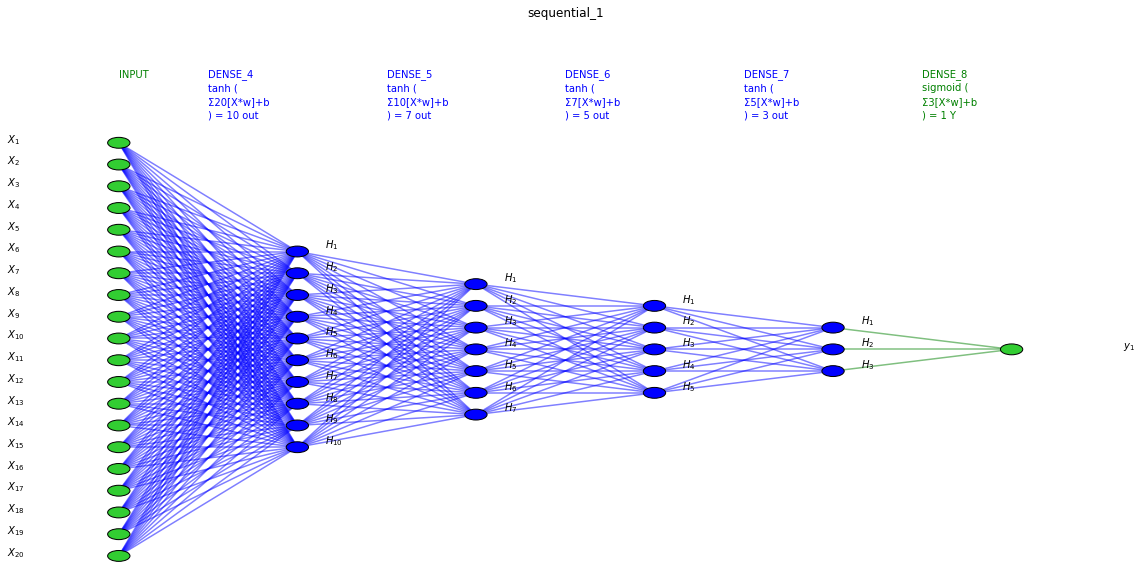

In [ ]:
# showing summary viz of my second model
visualize_nn(cl2_model, description=True, figsize=(20,10))

In [ ]:
# using binary_crossentropy
# compiling second model, setting metrics = ['acc']

cl2_model.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

In [ ]:
# fitting my second model
history = cl2_model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 100, verbose =0)

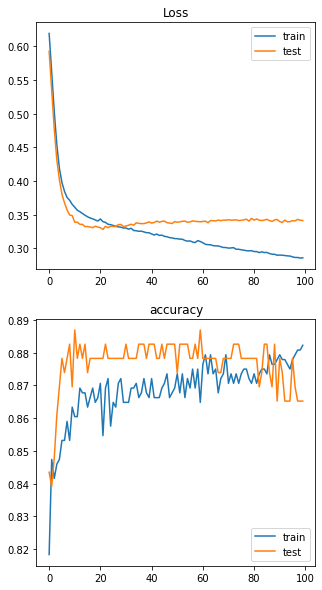

In [ ]:
# displaying second model performance
plot_history(history, 'accuracy')

>Our loss and accuracy show a slight overfit. I used Tanh as my activation with an extra layer spread out between 11 and 1.

#2nd Model Metrics Report

Training Evaluation:

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.85      0.87       307
   Heart Disease       0.88      0.91      0.90       381

        accuracy                           0.88       688
       macro avg       0.88      0.88      0.88       688
    weighted avg       0.88      0.88      0.88       688



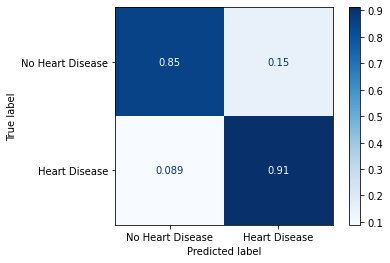

Testing Evaluation:

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.81      0.84       103
   Heart Disease       0.85      0.91      0.88       127

        accuracy                           0.87       230
       macro avg       0.87      0.86      0.86       230
    weighted avg       0.87      0.87      0.86       230



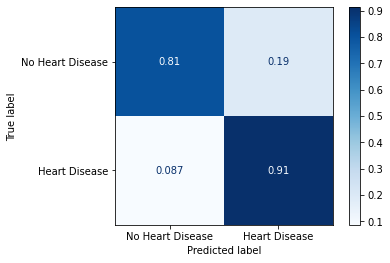

In [ ]:
# predicitons and evaluating second model
# defining labels for my confusion matrix
labels = ['No Heart Disease', 'Heart Disease']

# getting predictions and rounding them to integers instead of floats
train_preds = np.rint(cl_model.predict(X_train_proc))
test_preds = np.rint(cl_model.predict(X_test_proc))

# evaluating training set
print('Training Evaluation:\n')
evaluate_classification(y_train, train_preds, labels=labels,
                        normalize='true')
print('Testing Evaluation:\n')
# showing confusion Matrix
evaluate_classification(y_test, test_preds, labels=labels,
                        normalize='true')

>No significant improvements with Tanh and an extra hidden layer. My last attempt will involve ReLU with one more layer.

#3rd Model Deployment
Adding one last layer

In [ ]:
# building binary classification (cl3) model

# instantiating the third model
cl3_model = Sequential()

# creating input layer
cl3_model.add(Dense(10, activation= 'relu', input_dim = X_train_proc.shape[1]))

# creating hidden layer 1
cl3_model.add(Dense(8, activation= 'relu'))

# creating hidden layer 2
cl3_model.add(Dense(6, activation= 'relu'))

# creating hidden layer 3
cl3_model.add(Dense(4, activation= 'relu'))

# creating hidden layer 4
cl3_model.add(Dense(2, activation= 'relu'))

# creating output layer, binary class requires my activation fx of my final layer to be sigmoid
cl3_model.add(Dense(1, activation='sigmoid'))

# displaying my model details
cl3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                210       
                                                                 
 dense_10 (Dense)            (None, 8)                 88        
                                                                 
 dense_11 (Dense)            (None, 6)                 54        
                                                                 
 dense_12 (Dense)            (None, 4)                 28        
                                                                 
 dense_13 (Dense)            (None, 2)                 10        
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
Total params: 393
Trainable params: 393
Non-trainable 

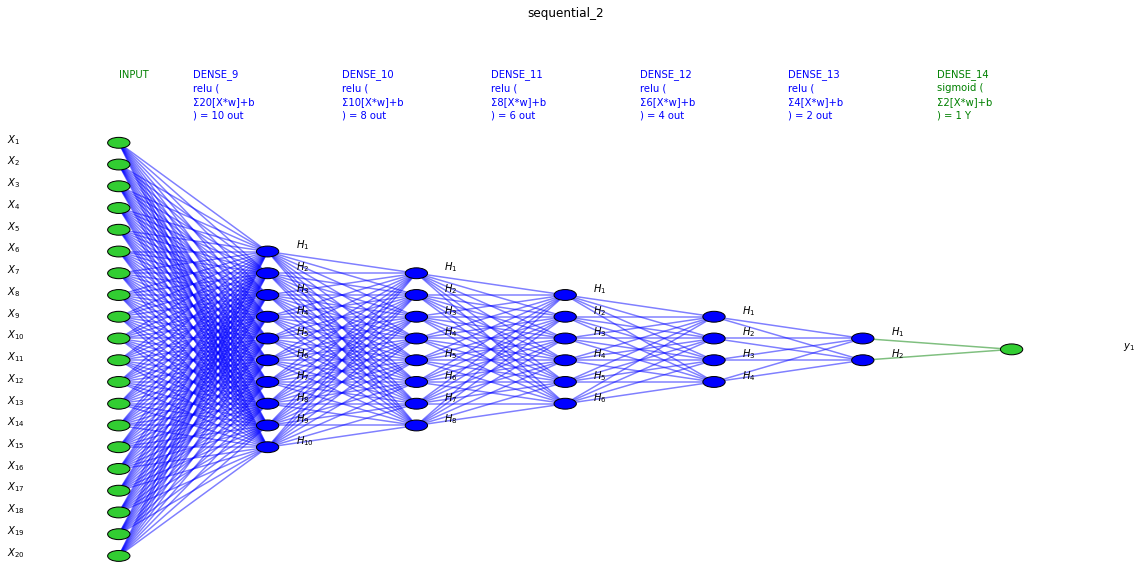

In [ ]:
# showing summary viz of my third model
visualize_nn(cl3_model, description=True, figsize=(20,10))

In [ ]:
# using binary_crossentropy
# compiling third model, setting metrics = ['acc']

cl3_model.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

In [ ]:
# fitting my third model
history = cl3_model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 100, verbose =0)

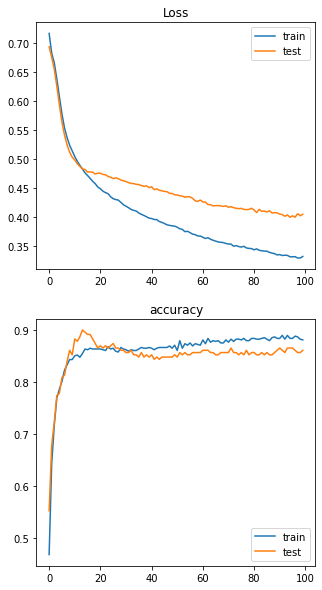

In [ ]:
# displaying third model performance
plot_history(history, 'accuracy')

>Our loss and accuracy show even more overfit. I used ReLU as my activation with one last layer. Deep learning with more layers alone will not handle this overfit.


Training Evaluation:

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.85      0.87       307
   Heart Disease       0.88      0.91      0.90       381

        accuracy                           0.88       688
       macro avg       0.88      0.88      0.88       688
    weighted avg       0.88      0.88      0.88       688



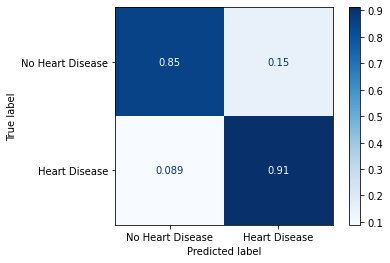

Testing Evaluation:

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.81      0.84       103
   Heart Disease       0.85      0.91      0.88       127

        accuracy                           0.87       230
       macro avg       0.87      0.86      0.86       230
    weighted avg       0.87      0.87      0.86       230



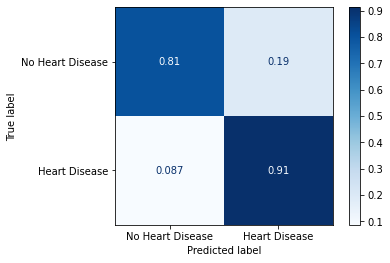

In [ ]:
# predicitons and evaluating third model
# defining labels for my confusion matrix
labels = ['No Heart Disease', 'Heart Disease']

# getting predictions and rounding them to integers instead of floats
train_preds = np.rint(cl_model.predict(X_train_proc))
test_preds = np.rint(cl_model.predict(X_test_proc))

# evaluating training set
print('Training Evaluation:\n')
evaluate_classification(y_train, train_preds, labels=labels,
                        normalize='true')
print('Testing Evaluation:\n')
# showing confusion Matrix
evaluate_classification(y_test, test_preds, labels=labels,
                        normalize='true')

>No significant change to my last report.

#Conclusion

>Adding more layers will not always provide better test performance metrics. May need to attack this high variance with a dropout, early stopping, regularization and/or decreasing my model's complexity.